#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 09
**CH09A Estimating gender and age differences in earnings**

using the cps-earnings dataset

version 1.0 2021-05-05 (modified 11.11.2023)

## Recap
### Statistical inference
-> what is the value of $\beta$ in the general pattern represented by the data if we know its estimated value $\hat{\beta}$?

#### Confidence interval CI: 
The 95\% CI around $\hat{\beta}$ gives range in which we can expect $\beta$ (in the population) to lie with 95\% confidence 

-> $CI_{95\%}= \{\hat{\beta}\pm 2 SE(\hat{\beta})\} = [\hat{\beta} - 2 SE(\hat{\beta}), \hat{\beta} + 2 SE(\hat{\beta})]$

SE can be estimated 
- bootstrap
- simple formula, i.e. homoskedasticity) $SE(\hat{\beta})=\frac{Std[e]}{\sqrt{n}Std[x]}$
- robust formula

From the simple formula

-> $SE\downarrow$ (narrower CI, i.e. more precise estimate of $\beta$) as 
- $Std[e]\downarrow$ (smaller errors, better fit)
- $Std[x]\uparrow$ (more variation in x)
- $\sqrt{n}\uparrow$ (more observations)

**Homoskedasticity**: the fit of the regression line is the same across the entire range of $x$ -> usually not true

**Heteroskedasticity**: fit may differ at different values of $x$ (spread of actual $y$ around regression is different)

In practice, we use a robust SE formula

### CI of regression line vs preditiction interval

*CI of $\hat{y}$ or regression line*: uncertainty about $\hat\alpha$ and $\hat\beta$
- tells us where is $y^E$ in the general pattern represented by our data (knowing $x$ and having $\hat\alpha$ and $\hat\beta$) 

-> **where to expect the average value of $y_j$ knowing $x_j$**

$CI(\hat{y}_j)_{95\%} = \hat{y_j} \pm 2 SE(\hat{y}_j)$

$SE(\hat{y}_j) = Std[e]\sqrt{\frac{1}{n} + \frac{(x_j-\bar{x})^2}{nVar[x]}}$ (homoskedasticity)

-> narrower CI when SE smaller 
- $Std[e]\downarrow$
- $Std[x]\uparrow$
- $n\uparrow$ 
- $x_j$ closer to $\bar{x}$



*Prediction interval (PI)*: uncertainty about $\hat\alpha$, $\hat\beta$ and $\varepsilon_i$
- tells us where actual $y_j$ is in the general pattern (knowing $x_j$ and having $\hat\alpha$ and $\hat\beta$)

-> **where to expect $y_j$ knowing $x_j$**

$PI(\hat{y}_j)_{95\%} = \hat{y}_j \pm 2 SPE(\hat{y}_j)$

$SPE(\hat{y}_j) = Std[e]\sqrt{1+\frac{1}{n} + \frac{(x_j-\bar{x})^2}{nVar[x]}}$ (homoskedasticity)

-> Additional uncertainty: the actual $y_j$ value is expected to be spread around its average value. The magnitude of this spread is best estimated by the standard deviation of the residual.


### Hypothesis testing - steps

1. Select the statistic to test
2. State the null and alternative hypotheses. They are about the “true” value: the value of the coefficient in the population, or general pattern, represented by the data

Often $H_0: \beta = 0 $,  $H_1: \beta \ne 0 $

3. Calculate or read the appropriate t-statistic

$t = \frac{\hat\beta - 0}{SE(\hat\beta)}$

4. Choose a critical value (or values) 

Significance level 5\% with critical values $\pm$ 1.96
- Reject the null if the absolute value of the t-statistic is outside the range defined by the critical value(s); don’t reject otherwise.

$|t|>$ critical value = 1.96

- Reject if p-value < significance level; don't otherwise 

p-value < significance level = 0.05

## Case study A
Find if the earnings of women and men tend to be different in US in market analysts and marketing specialists occupations


## Case study B
Early-career market analysts might want to predict how they can expect their earnings to change throughout their career

with both case studies -> generalization of results
- what to expect in the future?
- are there systematic differences? (external validity, not answered here)

## Set up
- statsmodels.nonparametric.kernel_regressions - loess method

In [148]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

warnings.filterwarnings("ignore")


In [149]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("TAsessions")[0]

# location folders
data_in = dirname + "TAsessions/da_data_repo/cps-earnings/clean/"
data_out = dirname + "TAsessions/ch09-gender-age-earnings/"
output = dirname + "TAsessions/ch09-gender-age-earnings/output/"
func = dirname + "TAsessions/ch00-tech-prep/"
sys.path.append(func)


In [150]:
# Import the prewritten helper functions
from py_helper_functions import *


In [151]:
data_all = pd.read_csv(data_in + "morg-2014-emp.csv")

2014 CPS data: Current Population Survey of the USA on adult population (already cleaned dataset)

### SELECT OCCUPATION

keep only two occupation types: Market research analysts and marketing specialists and Computer and Mathematical Occupations

(for this case study we start with Market analysts)

(look at CPS occupation codes file)

In [152]:
data_all.loc[data_all["occ2012"] == 735, "sample"] = 1 #Market research analysts and marketing specialists
# sample == 1
data_all.loc[
    ((data_all["occ2012"] >= 1005) & (data_all["occ2012"] <= 1240)), "sample"
] = 2 #Computer and Mathematical Occupations
# sample == 2
data_all.loc[data_all["sample"].isna(), "sample"] = 0 # were NAs input zeros
# sample == 0
data_all

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work,0.0
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent,0.0
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work,0.0
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work,0.0
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149311,317051,896679860459501,December,WY,346.2296,692.30,40,39,1,NaN,...,0,"Native, Born In US",8,Office supplies and stationery stores (45321),4760,"Private, For Profit",No,No,Employed-At Work,0.0
149312,317052,907086820569600,December,WY,294.9800,1984.61,40,44,1,NaN,...,3,"Native, Born In US",8,Administration of human resource programs (923),430,Government - State,No,No,Employed-At Work,0.0
149313,317053,907086820569600,December,WY,324.1761,2884.61,55,43,1,NaN,...,3,"Native, Born In US",8,Nursing care facilities (6231),10,"Private, For Profit",No,No,Employed-At Work,0.0
149314,317055,950868097156649,December,WY,321.6982,1153.84,40,42,1,NaN,...,0,"Native, Born In US",8,Hospitals (622),5820,"Private, Nonprofit",No,No,Employed-At Work,0.0


In [153]:
data_all = data_all.loc[
    (data_all["sample"] == 1) | (data_all["sample"] == 2), :
].reset_index(drop=True) #keep only sample == 1, sample == 2
data_all

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample
0,33,731019430119001,January,AL,2992.1015,1538.46,40,43,2,NaN,...,0,"Native, Born In US",63,"Electric power generation, transmission and di...",1006,"Private, For Profit",No,No,Employed-At Work,2.0
1,346,673032906039520,January,AK,411.5571,1346.15,40,39,3,NaN,...,0,"Native, Born In US",94,Executive offices and legislative bodies (9211...,1030,Government - Local,No,No,Employed-At Work,2.0
2,651,207004430306994,January,AZ,3410.8853,2500.00,40,44,4,NaN,...,0,"Foreign Born, US Cit By Naturalization",86,Computer systems design and related services (...,1020,"Private, For Profit",No,No,Employed-At Work,2.0
3,657,236096309400800,January,AZ,3916.3279,2500.00,40,43,4,NaN,...,10,"Foreign Born, US Cit By Naturalization",86,Business support services (5614),1020,"Private, For Profit",No,No,Employed-At Work,2.0
4,724,914299270769003,January,AZ,5115.4707,1250.00,45,43,1,NaN,...,0,"Native, Born In US",86,Computer systems design and related services (...,1020,"Private, For Profit",No,No,Employed-At Work,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,316454,207506700510944,December,WI,3480.7339,1364.50,40,43,1,NaN,...,0,"Native, Born In US",3,Computer systems design and related services (...,1010,"Private, For Profit",No,No,Employed-At Work,2.0
5017,316553,55621016909598,December,WI,417.4886,1673.07,40,43,1,NaN,...,4,"Native, Born In US",3,"Navigational, measuring, electromedical, and c...",1020,"Private, For Profit",No,No,Employed-At Work,2.0
5018,316585,165596089500912,December,WI,371.3748,1750.00,43,43,1,NaN,...,0,"Native, Born In US",3,Computer systems design and related services (...,1050,"Private, For Profit",No,No,Employed-At Work,2.0
5019,316694,706900345996715,December,WI,2364.8294,1634.61,40,43,1,NaN,...,8,"Native, Born In US",3,Computer systems design and related services (...,1020,"Private, For Profit",No,No,Employed-At Work,2.0


In [154]:
data_all["sample"].value_counts()
# 281 market research analyst and marketing specialist occupation

sample
2.0    4740
1.0     281
Name: count, dtype: int64

Create variables
- female 
- hourly wages
- log of hourly wages (dependent variable)
- age squared

In [155]:
data_all["female"] = (data_all["sex"] == 2)
data_all["w"] = data_all["earnwke"] / data_all["uhours"]
data_all["lnw"] = np.log(data_all["w"])
data_all["agesq"] = np.power(data_all["age"], 2)


In [156]:
i = 1 # we consider only market analysts here
data = data_all.loc[data_all["sample"] == i, :].reset_index(drop=True)
data.to_csv(data_out + "earnings_inference.csv", index=False)


### DISTRIBUTION OF EARNINGS

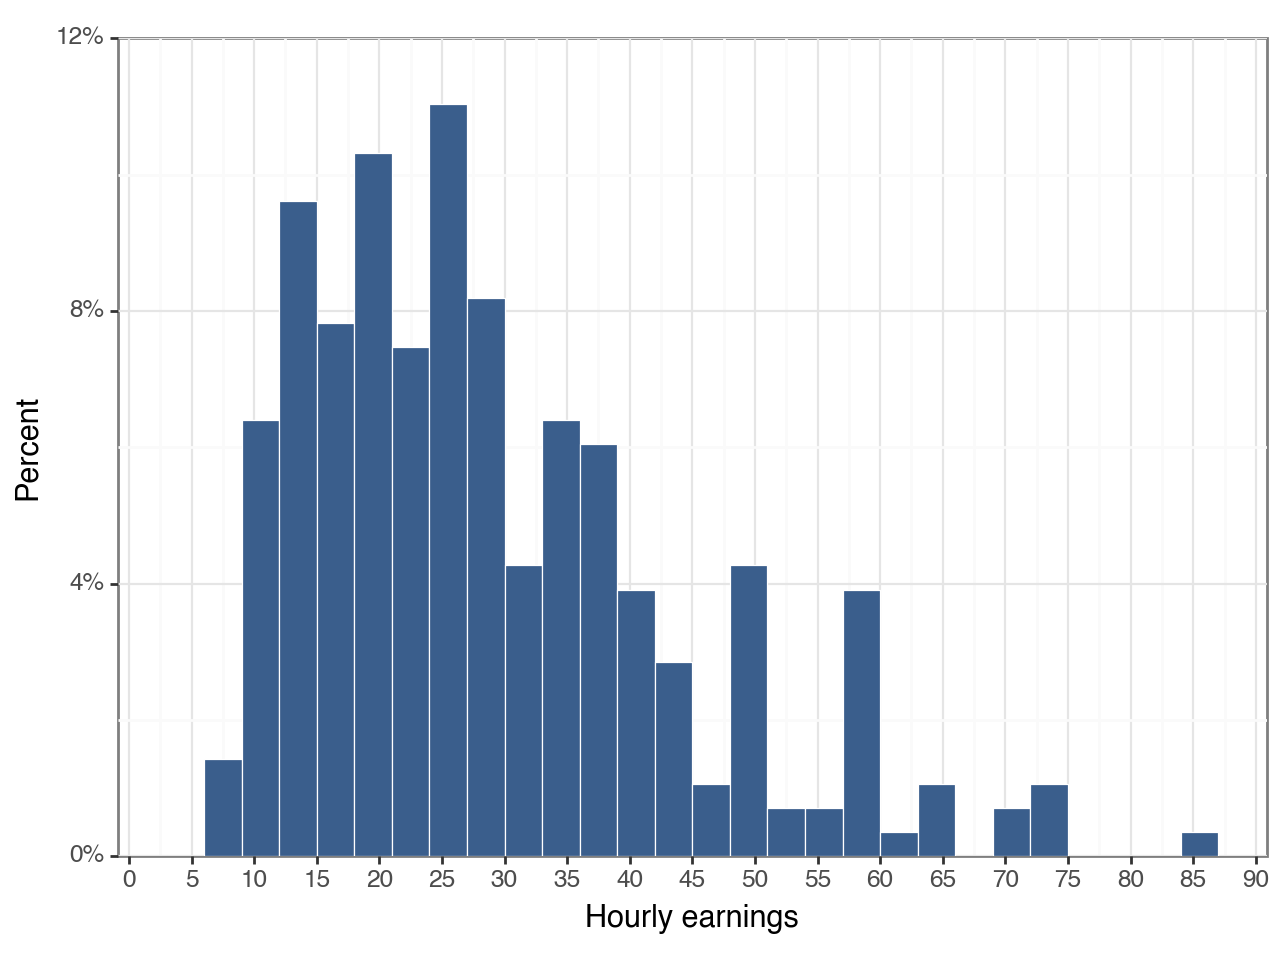

<Figure Size: (640 x 480)>

In [157]:
(
    ggplot(data, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90), breaks=seq(0, 90, 5))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        breaks=seq(0, 0.12, 0.04),
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


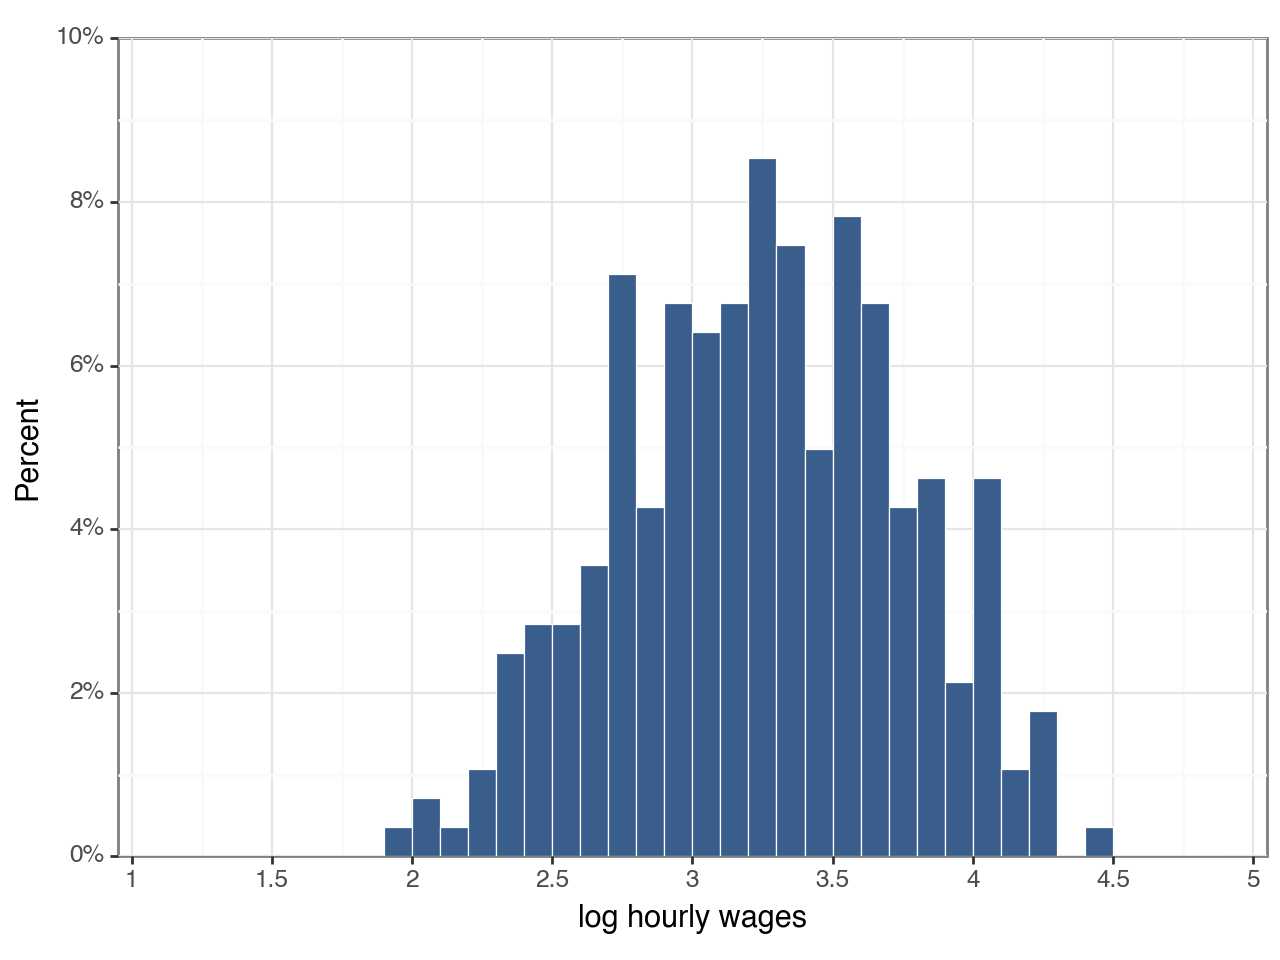

<Figure Size: (640 x 480)>

In [158]:
(
    ggplot(data, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

In [159]:
data.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,281.000000,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656,3.245683
std,709.545222,10.325838,14.712495,0.503682
min,40.000000,5.000000,7.250000,1.981001
25%,700.000000,40.000000,17.788250,2.878538
50%,1096.150000,40.000000,25.950000,3.256172
75%,1538.000000,40.000000,37.019000,3.611431
max,2884.610000,80.000000,84.600000,4.437934


In [160]:
#data.loc[data["w"] >= 1, ["earnwke", "uhours", "w",]].describe()


In [161]:
data["female"] = data["female"].astype(int)  
data["female"].value_counts()


female
1    172
0    109
Name: count, dtype: int64

In [162]:
data.groupby(["occ2012", "female"]).size()


occ2012  female
735      0         109
         1         172
dtype: int64

### Earnings and female - case study part A
#### Linear regressions
**Log-level**:

$(\ln{w})^E = \alpha + \beta \times female$


In [163]:
reg1 = smf.ols(formula="lnw~female", data=data).fit()
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.390
Date:                Sat, 11 Nov 2023   Prob (F-statistic):             0.0666
Time:                        20:30:06   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.048     69.004      0.000       3.220       3.409
female        -0.1131      0.061     -1.841      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Slope: female market analysts earn 11\% ($\beta\times 100\%$) less, on average than male market analysts in this data

what can university students expect about the gender gap in pay if they choose to become market analysts? (future)

-> do **statistical inference**

**Heteroskedastic robust SE**

In [164]:
reg2 = smf.ols(formula="lnw~female", data=data).fit(cov_type="HC1")
reg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.347
Date:                Sat, 11 Nov 2023   Prob (F-statistic):             0.0684
Time:                        20:30:10   Log-Likelihood:                -203.81
No. Observations:                 281   AIC:                             411.6
Df Residuals:                     279   BIC:                             418.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.049     67.810      0.000       3.219       3.411
female        -0.1131      0.062     -1.829      0.067      -0.234       0.008
==============================================================================
Omnibus:                        5.253   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.371
Skew:                          -0.070   Prob(JB):                        0.185
Kurtosis:                       2.482   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Robust SE slope: 0.06, CI $[-0.234,0.008]$ (wide)

-> in 2014 in the USA we can be 95\% confident that the average difference between hourly earnings of female market analysts versus male was -23\% to 1\%

-> the CI *includes* zero -> we cannot rule out with 95\% confidence that their average earnings (female and male) are the same 

-> $|t|=1.8<1.96$ cannot reject $H_0$

-> it can be seen also by p-value$> 0.05$

-> the coefficient cannot be considered statistically significant at 5\% (significant at 10\%)

### Table 9.1 Wage and gender gap baseline regression

In [165]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


In [ ]:
# extra (at the end): Bootstrap

In [ ]:
# exercise: replicate the same analysis with a different occupation 

### Earnings and age - case study part B

Learning the age pattern may help early-career market analysts predict how they can expect their earnings to change throughout their career.

In [166]:
reg3 = smf.ols(formula="lnw~age", data=data).fit(cov_type="HC1")
reg3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     26.36
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           5.31e-07
Time:                        20:30:14   Log-Likelihood:                -191.01
No. Observations:                 281   AIC:                             386.0
Df Residuals:                     279   BIC:                             393.3
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7317      0.101     27.006      0.000       2.533       2.930
age            0.0135      0.003      5.135      0.000       0.008       0.019
==============================================================================
Omnibus:                        1.782   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.708
Skew:                          -0.109   Prob(JB):                        0.426
Kurtosis:                       2.687   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Estimate on age is statistically significant at 1\% level 

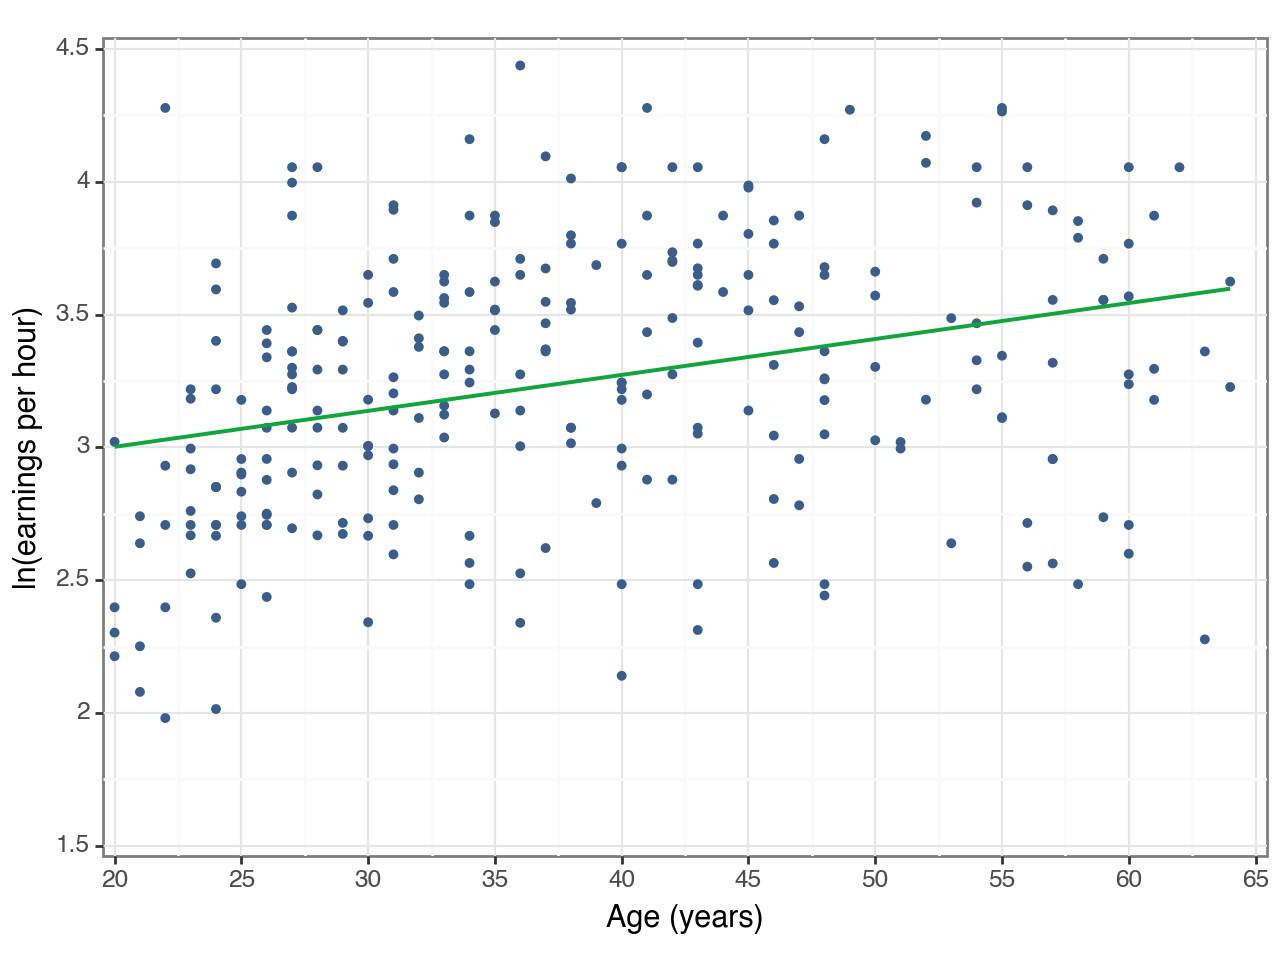

<Figure Size: (640 x 480)>

In [167]:
(
    ggplot(data, aes(x="age", y="lnw"),
    )
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", colour=color[1], se=False, size=0.8, linetype="solid")
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
)

### Figure 9.3 Log hourly wage and age: regressions that capture nonlinearity

(a) Lowess regression and scatterplot

In [168]:
reg6 = loess.KernelReg(data["lnw"], data["age"], var_type="c", reg_type="lc")

In [169]:
reg6

KernelReg instance
Number of variables: k_vars = 1
Number of samples:   N = 281
Variable types:      c
BW selection method: cv_ls
Estimator type: lc

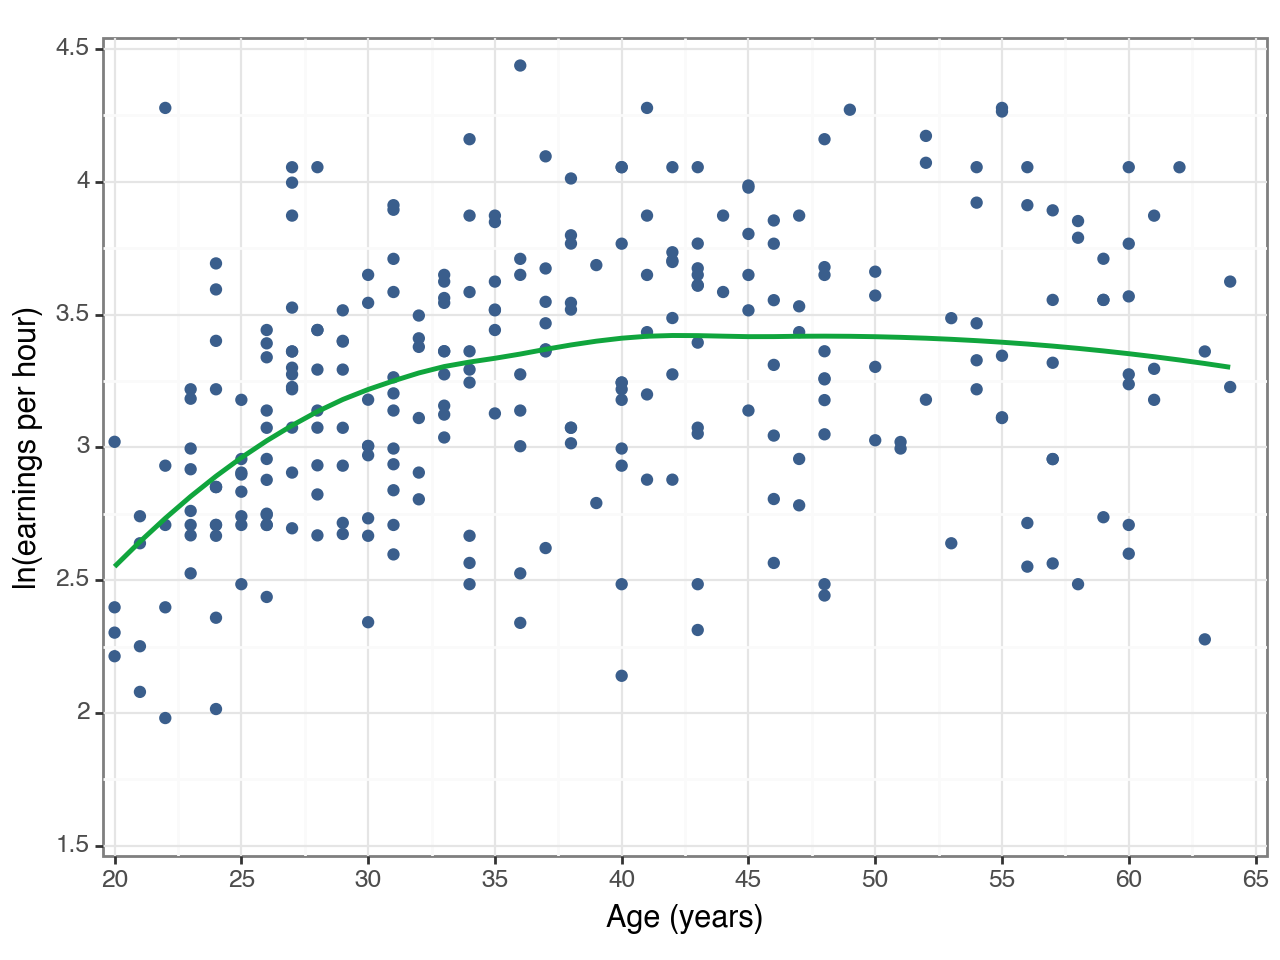

<Figure Size: (640 x 480)>

In [170]:
(
    ggplot(data, aes(x="age", y="lnw"))
    + geom_point(color=color[0])
    + geom_smooth(method="loess", color=color[1], se=False)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
)

Earnings are substantially higher for older ages among young adults: average log earnings is about 0.4 log unit, i.e. 50\%, higher for 25-year-old analysts than for 20-year-old analysts

Age differences are positive but get smaller and smaller as we compare older people; little or any difference by age [40,60]; those older than 60 earn less on average

- increasing for young
- flat middle
- slightly decreasing for older
-> concave

Now, we want to approximate the lowess curve with
- piecewise linear spline with knots at 30 and 40
- quadratic model

In [171]:
reg4 = smf.ols(formula="lnw~age+agesq", data=data).fit(cov_type="HC1")
reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     27.47
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           1.29e-11
Time:                        20:30:41   Log-Likelihood:                -179.58
No. Observations:                 281   AIC:                             365.2
Df Residuals:                     278   BIC:                             376.1
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1935      0.341      3.499      0.000       0.525       1.862
age            0.0962      0.018      5.360      0.000       0.061       0.131
agesq         -0.0010      0.000     -4.608      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        0.304   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.353
Skew:                          -0.078   Prob(JB):                        0.838
Kurtosis:                       2.924   Cond. No.                     2.22e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Concavity given by $\beta_2<0$

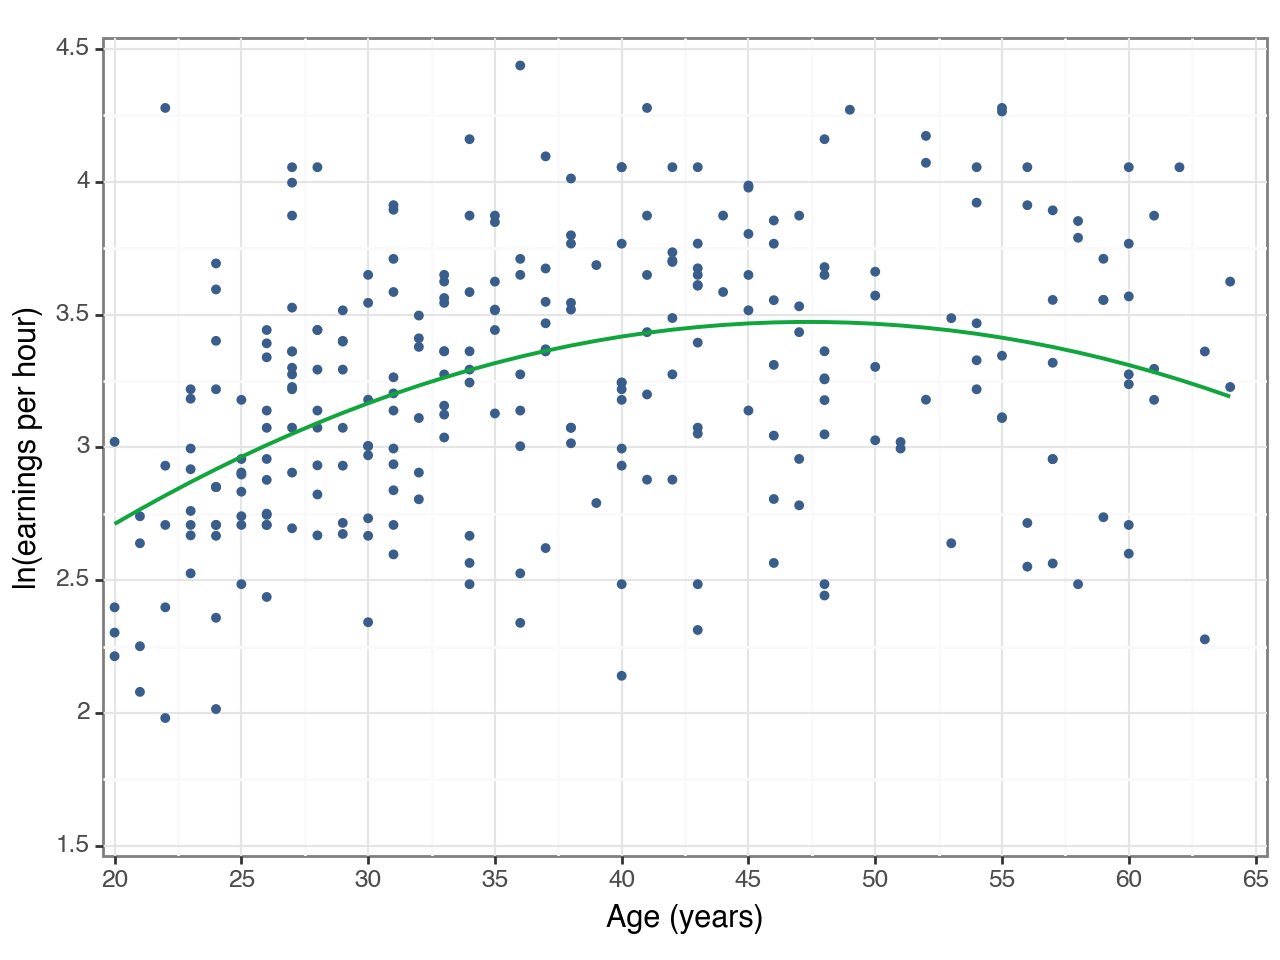

<Figure Size: (640 x 480)>

In [172]:
(
    ggplot(data, aes(x="age", y="lnw"),
    )
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + stat_smooth(method="lm", formula="y ~ poly(x,2)", colour=color[1], se=False, size=0.8, linetype="solid")
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
)

In [173]:
reg5 = smf.ols(formula="lnw~lspline(age,[30,40])", data=data).fit(cov_type="HC1")
reg5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     19.33
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           2.07e-11
Time:                        20:30:48   Log-Likelihood:                -178.88
No. Observations:                 281   AIC:                             365.8
Df Residuals:                     277   BIC:                             380.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.3834      0.369      3.753      0.000       0.661       2.106
lspline(age, [30, 40])[0]     0.0624      0.014      4.559      0.000       0.036       0.089
lspline(age, [30, 40])[1]     0.0165      0.010      1.680      0.093      -0.003       0.036
lspline(age, [30, 40])[2]    -0.0026      0.006     -0.444      0.657      -0.014       0.009
==============================================================================
Omnibus:                        0.184   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.147
Skew:                          -0.056   Prob(JB):                        0.929
Kurtosis:                       2.991   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**Compute prediction results**

In [174]:
z = reg4.get_prediction().conf_int()  #quadratic

In [175]:
res = reg4.get_prediction().summary_frame()
data["lnwpred_ageq"] = res["mean"]
data["lnwpred_ageqCIUP"] = [x[0] for x in z]
data["lnwpred_ageqCILO"] = [x[1] for x in z]


In [176]:
data["lnwpred_ageqCIUP"]

0      2.930318
1      3.286605
2      3.359392
3      3.359392
4      3.103177
         ...   
276    3.245388
277    3.196170
278    3.286605
279    3.387313
280    3.378548
Name: lnwpred_ageqCIUP, Length: 281, dtype: float64

In [177]:
z = reg5.get_prediction().conf_int()  #spline

In [178]:
res = reg5.get_prediction().summary_frame()
data["lnwpred_agesp"] = res["mean"]
data["lnwpred_agespCIUP"] = [x[0] for x in z]
data["lnwpred_agespCILO"] = [x[1] for x in z]


In [179]:
data["lnwpred_agel"] = reg6.fit()[0]

(b) Lowess, piecewise linear spline, and quadratic

In [180]:
plotdata = data.filter(["age", "lnwpred_agel", "lnwpred_ageq", "lnwpred_agesp"]).melt(
    id_vars=["age"]
)

In [181]:
plotdata

,age,variable,value
0,26,lnwpred_agel,3.052084
1,37,lnwpred_agel,3.363144
2,42,lnwpred_agel,3.408504
3,42,lnwpred_agel,3.408504
4,30,lnwpred_agel,3.184612
...,...,...,...
838,35,lnwpred_agesp,3.338981
839,33,lnwpred_agesp,3.305944
840,37,lnwpred_agesp,3.372019
841,48,lnwpred_agesp,3.400428


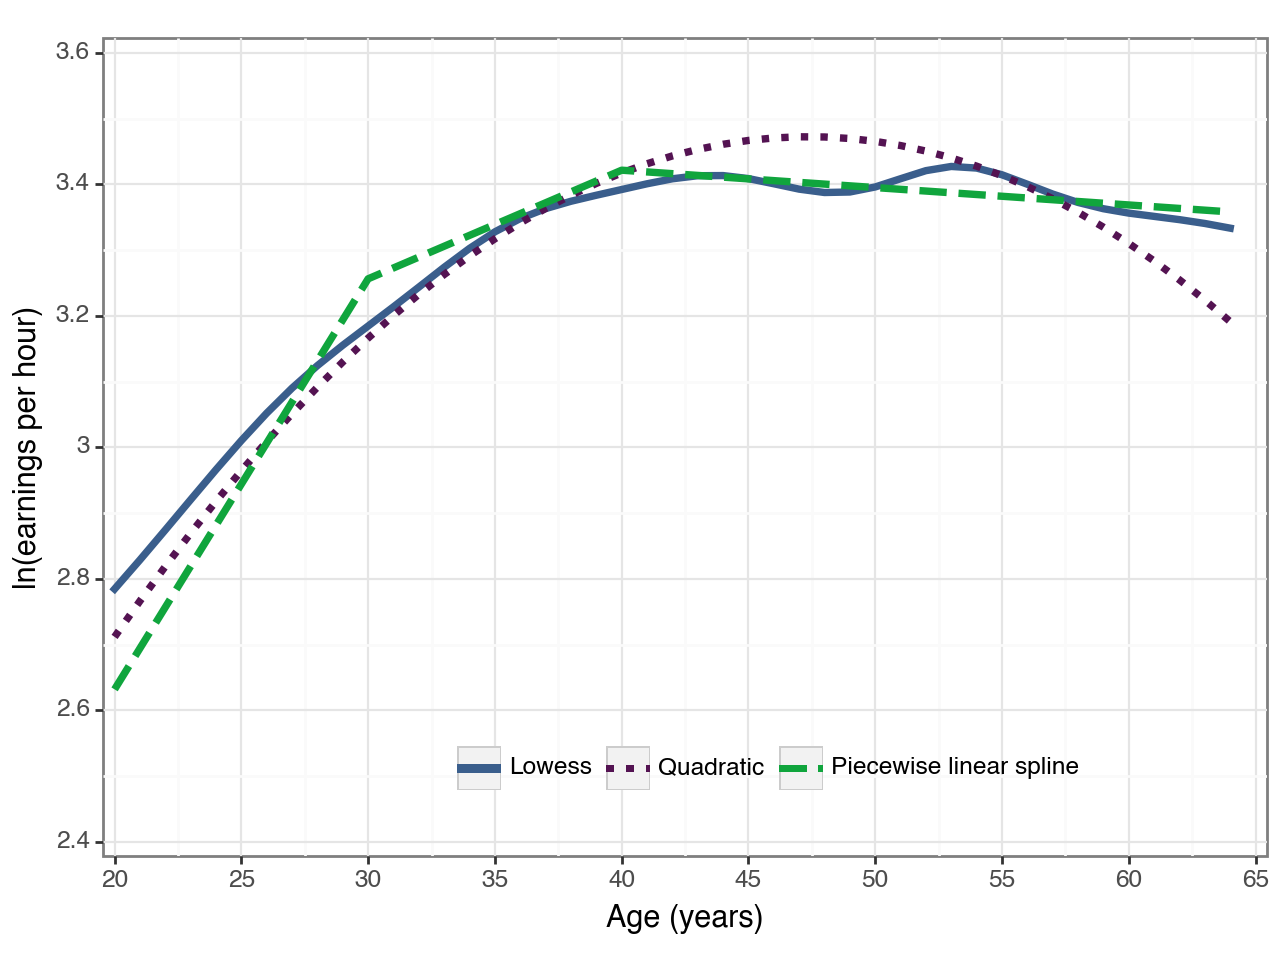

<Figure Size: (640 x 480)>

In [182]:
(
    ggplot(
        plotdata,
        aes(x="age", y="value", color="variable", linetype="variable"),
    )
    + geom_line(size=1.5)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 66, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.4, 3.6), breaks=seq(2.4, 3.6, by=0.20)
    )
    + scale_color_manual(
        values=[color[0], color[2], color[1]],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + scale_linetype_manual(
        values=["-", ":", "dashed"],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
    + theme(
        legend_position=(0.6, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
)

*piecewise linear spline* vs *loess*: 
- not capturing the smooth transition from steep to flat; 
- higher average earnings around 30
- good for average slopes between knots (not surprising)

*quadratic* vs *loess*:
- capturing smooth change in slopes
- close to loess below 35
- slightly too steep between 35 and 45
- way too steep for oldest (rigid symmetry of quadratic shape)

-> compare CI of predicted values

### Figure 9.4 Average log earnings and age: regressions with CI

same figure as before but add the 95\% confidence intervals to piecewise linear and quadratic regressions

In [185]:
plotdata = (
    data.filter(
        [
            "age",
            "lnwpred_agel",
            "lnwpred_ageq",
            "lnwpred_agesp",
            "lnwpred_ageqCIUP",
            "lnwpred_ageqCILO",
            "lnwpred_agespCIUP",
            "lnwpred_agespCILO",
        ]
    )
    .melt(id_vars=["age"]) #
    .assign(CI=lambda x: x["variable"].str.contains("CI")) 
    .assign(
        estimate=lambda x: np.where(x["CI"], x["variable"].str[:-4], x["variable"]),
    )
)

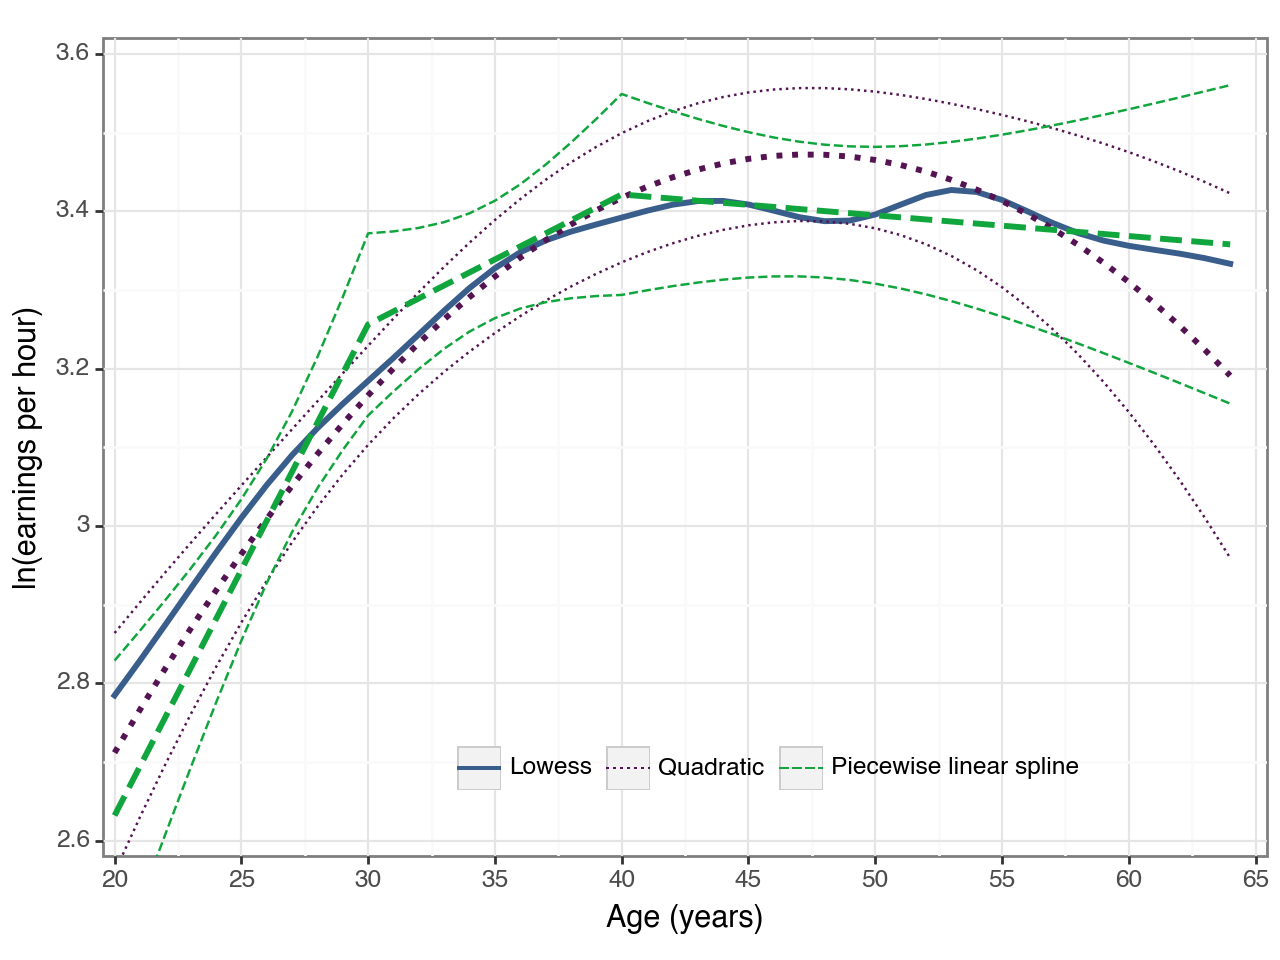

<Figure Size: (640 x 480)>

In [186]:
(
    ggplot(
        plotdata,
        aes(
            x="age",
            y="value",
            group="variable",
            color="estimate",
            linetype="estimate",
            size="CI",
        ),
    )
    + geom_line()
    + coord_cartesian(xlim=(20, 65), ylim=(2.6, 3.6))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.4, 3.6), breaks=seq(2.4, 3.6, by=0.20)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + scale_color_manual(
        values=[color[0], color[2], color[1]],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + scale_linetype_manual(
        values=["-", ":", "dashed"],
        labels=["Lowess", "Quadratic", "Piecewise linear spline"],
    )
    + scale_size_manual(values=(1.2, 0.5), guide=False)
    + theme_bw()
    + theme(
        legend_position=(0.6, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
)

- lowess regression line is withing the CI bounds of both regressions
- the quadratic is withing the CI bounds of piecewise linear spline and viceversa (except at 30)

-> both are pretty good at capturing the general pattern

(might be because we have few observations -> wide bounds but the steep and flat parts are well captured)

- What can students expect about how their earnings may change if they choose market analyst occupations? rise fast until 30, then slowly until 40-45, above should not increase much 
- External validity? Not much can be said since we are considering only age -> better to take away only the qualitative findings (not the numerical estimates

### Table 9.2 Wage and age – different specifications

In [29]:
stargazer = Stargazer([reg3, reg4, reg5])
stargazer.covariate_order(
    [
        "age",
        "agesq",
        "lspline(age, [30, 40])[0]",
        "lspline(age, [30, 40])[1]",
        "lspline(age, [30, 40])[2]",
        "Intercept",
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "agesq": "age squared",
        "lspline(age, [30, 40])[0]": "age spline <30",
        "lspline(age, [30, 40])[1]": "age spline 30–40",
        "lspline(age, [30, 40])[2]": "age spline 40<",
    }
)
stargazer


(1) Linear specification: market analysts that are 1 year older are expected to earn 1.4\% more on average (in this sample)

-> we saw that the pattern is non-linear: this average difference is not very informative if we are interested in the evolution during the career

(2) Quadratic specification: no interpretation of the coefficient on age; concave pattern indicated by the negative coefficient on age squared 

-> statistically significant -> concavity is likely to be true in the population

(3) Piecewise linear spline with 2 knots (30, 40): 
- among market analysts between 20 and 30, those 1 year older are expected to have 6\% higher earnings -> significant at 1\%

- between 30 and 40, those 1 year older are expected to have 1.7\% higher earnings -> significant only at 10\%

- above 40, estimate not statistically different from 0

In [187]:
# EXTRA

## CI vs PI

### Figure 9.2 Log hourly wage and age: regression line, confidence interval, prediction interval.

In [40]:
reg7 = smf.ols(formula="lnw~age", data=data.loc[data["sample"] == 1]).fit()

(a) Confidence interval

In [41]:
pred_confidence = data.join(
    pd.DataFrame(reg7.get_prediction().conf_int(), columns=["lwr", "upr"])
).join(reg7.get_prediction().summary_frame()["mean"].rename("fit"))

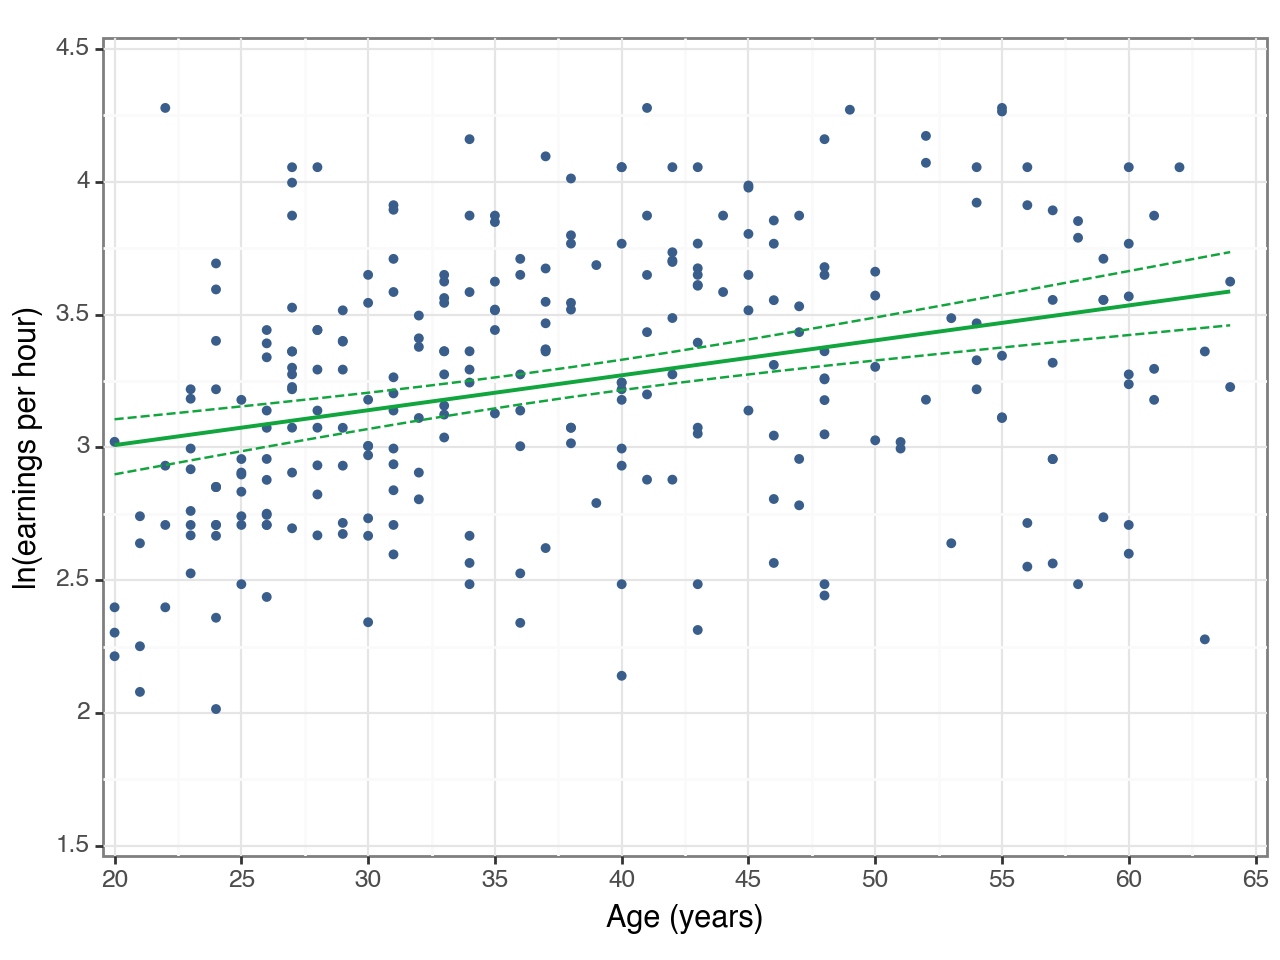

<Figure Size: (640 x 480)>

In [42]:
(
    ggplot(
        pred_confidence.loc[lambda x: (x["lnw"] < 4.4) & (x["lnw"] > 2)],
        aes(x="age", y="lnw"),
    )
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", colour=color[1], se=False, size=0.8, linetype="solid")
    + geom_line(
        pred_confidence,
        aes(x="age", y="lwr"),
        size=0.5,
        linetype="dashed",
        colour=color[1],
    )
    + geom_line(
        pred_confidence,
        aes(x="age", y="upr"),
        size=0.5,
        linetype="dashed",
        colour=color[1],
    )
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + scale_linetype_manual(
        name="",
        values=(1, 1, 2),
        labels=("Lowess", "Confidence interval (95%)", "Confidence interval (95%)"),
    )
    + theme_bw()
)


(b) Prediction interval

In [43]:
pred_interval = data
pred_interval[["lwr", "upr"]] = (
    reg7.get_prediction().summary_frame().loc[:, ["obs_ci_lower", "obs_ci_upper"]]
)
pred_interval = pred_interval.join(
    reg7.get_prediction().summary_frame()["mean"].rename("fit")
)


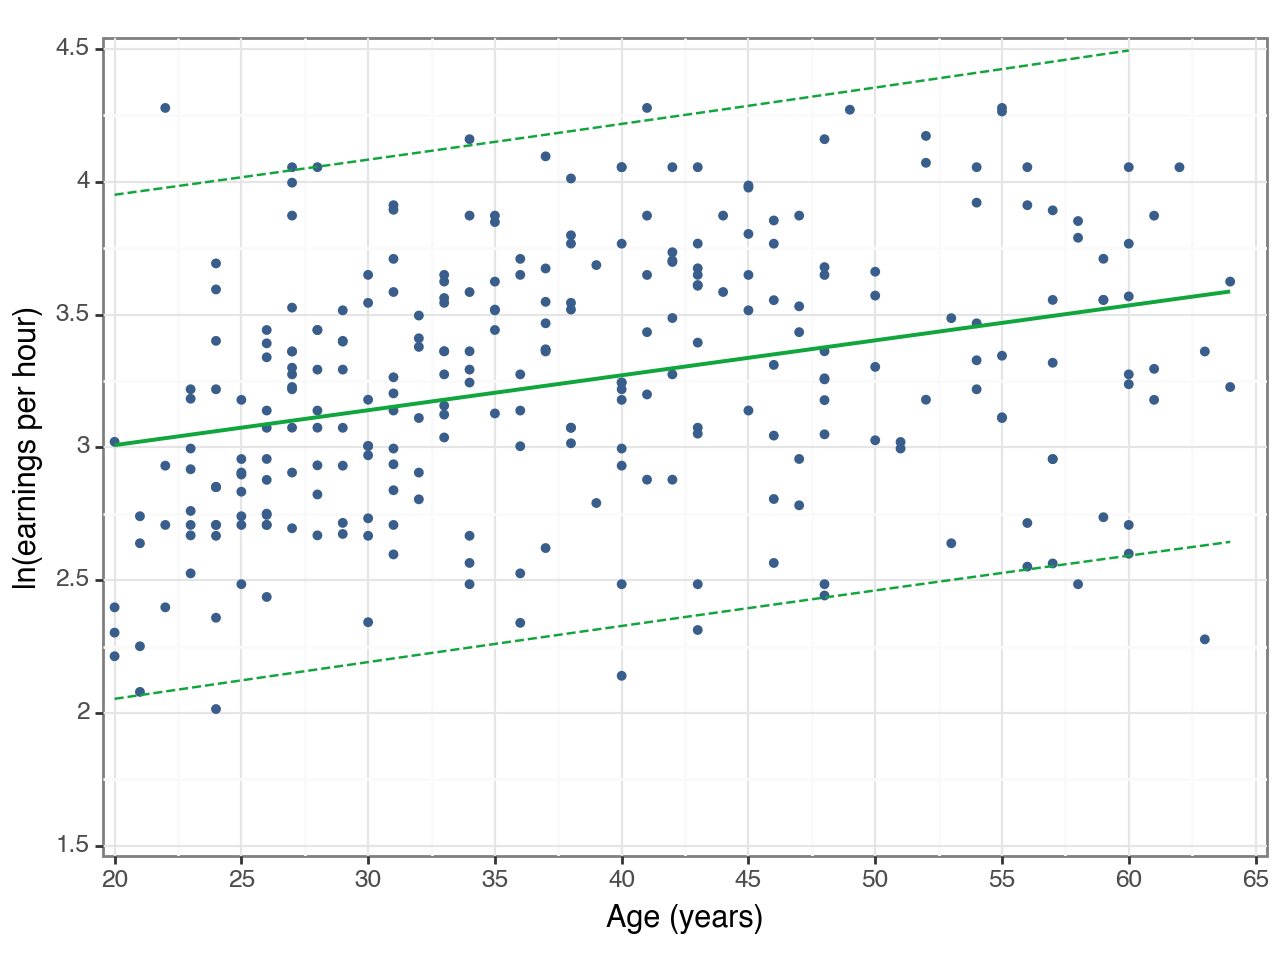

<Figure Size: (640 x 480)>

In [44]:
(
    ggplot(
        pred_interval.loc[lambda x: (x["lnw"] < 4.4) & (x["lnw"] > 2)],
        aes(x="age", y="lnw"),
    )
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", colour=color[1], se=False, size=0.8, linetype="solid")
    + geom_line(
        pred_interval, aes(y="lwr"), size=0.5, linetype="dashed", colour=color[1]
    )
    + geom_line(
        pred_interval, aes(y="upr"), size=0.5, linetype="dashed", colour=color[1]
    )
    + coord_cartesian(xlim=(20, 65), ylim=(1.5, 4.5))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="Age (years)", y="ln(earnings per hour)")
    + theme_bw()
)


## Bootstrap

### Figure 9.1 Bootstrap distribution of the average female–male wage difference among market analysts

In [45]:
data = pd.read_csv(data_out + "earnings_inference.csv")


In [46]:
def bs_linreg(x, y, size=1, seed=200999):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    rng = np.random.default_rng(seed)
    # Take samples
    for i in range(size):
        bs_inds = rng.choice(inds, len(inds), replace=True)
        bs_x, bs_y = sm.add_constant(x[bs_inds]), y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = (
            sm.regression.linear_model.OLS(bs_y, bs_x).fit().params
        )

    return bs_slope_reps, bs_intercept_reps

In [47]:
results = bs_linreg(data.lnw.values, data.female.values, size=1000)

b_earnings_female = pd.DataFrame(results).T

b_earnings_female.columns = ["_b_intercept", "_b_female"]


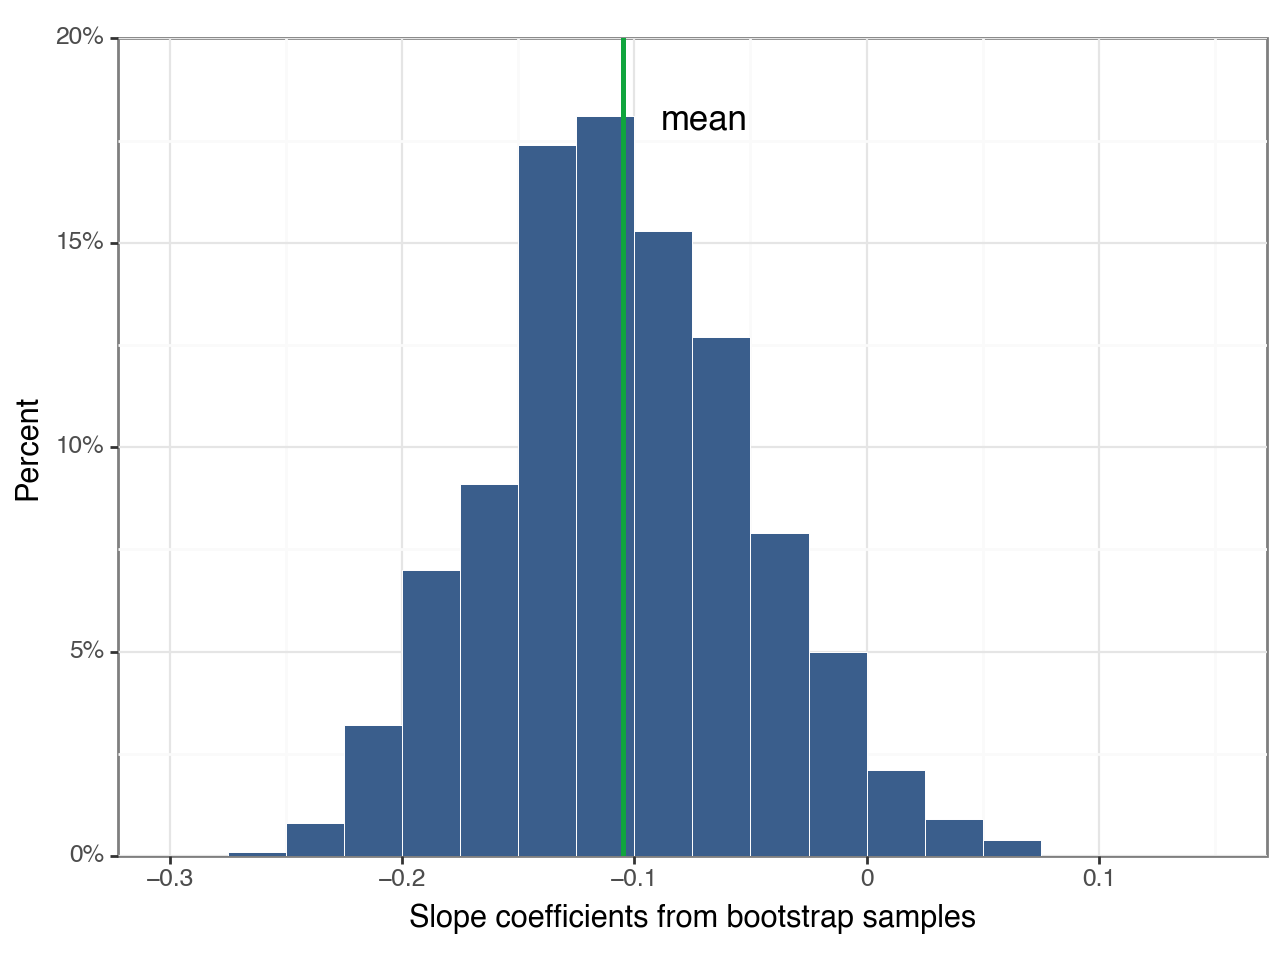

<Figure Size: (640 x 480)>

In [48]:
(
    ggplot(b_earnings_female, aes(x="_b_female"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.025,
        center=0.0125,
        closed="left",
        color="white",
        fill=color[0],
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(
        aes(
            x=b_earnings_female["_b_female"].mean(),
            y=0,
            xend=b_earnings_female["_b_female"].mean(),
            yend=0.2,
        ),
        colour=color[1],
        size=1,
    )
    + annotate("text", x=-0.07, y=0.18, label="mean", size=12.5)
    + coord_cartesian(xlim=(-0.3, 0.15), ylim=(0, 0.2))
    + labs(x="Slope coefficients from bootstrap samples", y="Percent")
    + scale_y_continuous(expand=(0.0, 0.0), limits=(0, 0.2), labels=percent_format())
    + theme_bw()
)
